In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, Input, Conv2D, UpSampling2D, Conv2DTranspose, Flatten, Reshape
from keras.layers import BatchNormalization, Dropout, Activation, MaxPool2D, concatenate
from keras.models import Model

from skimage import color

In [24]:
data = np.load('.npzs/pfcn.npz')

train_images = data['train_images']
test_images = data['test_images']
train_mattes = data['train_mattes']
test_mattes = data['test_mattes']

In [25]:
np.shape(train_images), np.shape(
    test_mattes), train_mattes.min(), train_mattes.max()

((1700, 100, 75, 3), (300, 100, 75), 0.0, 1.0)

In [26]:
# train_mattes = color.gray2rgb(train_mattes)
# test_mattes = color.gray2rgb(test_mattes)
train_mattes_reshape = np.reshape(train_mattes, (1700, 100, 75, 1))
test_mattes_reshape = np.reshape(test_mattes, (300, 100, 75, 1))

Text(0.5, 1.0, 'result(X*Y), back black fill')

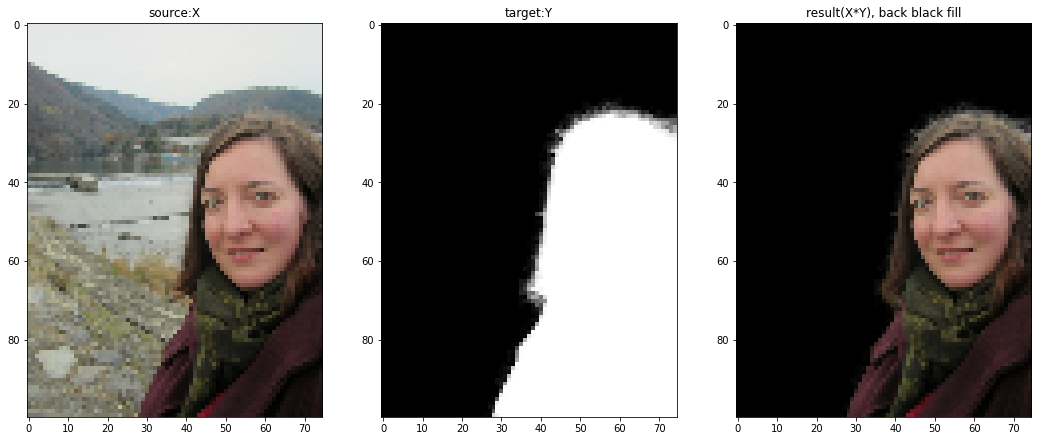

In [27]:
plt.figure(figsize=(18, 10))

plt.subplot(1, 3, 1)
plt.imshow(train_images[2])
plt.title('source:X')

plt.subplot(1, 3, 2)
plt.imshow(train_mattes_reshape[2], cmap='gray')
plt.title('target:Y')

plt.subplot(1, 3, 3)
plt.imshow(train_images[2] * train_mattes_reshape[2])
plt.title('result(X*Y), back black fill')

In [28]:
# 오토인코더 제작
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
def ae_like():
    inputs = Input((100, 75, 3))
    x = Conv2D(32, 3, 2, activation='relu', padding='same')(inputs)
    x = Conv2D(64, 3, 2, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, 2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    latent = Dense(10)(x)

    x = Dense((13 * 10 * 128))(latent)
    x = Reshape((13, 10, 128))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (2, 2), (1, 1), activation='relu', padding='valid')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (1, 1), (1, 1), activation='relu', padding='valid')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(32, (1, 2), (1, 1), activation='relu', padding='valid')(x)

    x = Conv2D(1, (1, 1), (1, 1), activation='sigmoid')(x)

    model = Model(inputs, x)

    return model

In [29]:
model = ae_like()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 75, 3)]      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 38, 32)        896       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 25, 19, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 10, 128)       73856     
_________________________________________________________________
flatten_2 (Flatten)          (None, 16640)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                166410    
_________________________________________________________________
dense_5 (Dense)              (None, 16640)             1830

In [30]:
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
hist = model.fit(train_images,
                 train_mattes,
                 validation_data=(test_images, test_mattes),
                 epochs=5)

Epoch 1/5
54/54 [==============================] - 2s 21ms/step - loss: 0.2237 - accuracy: 0.7495 - val_loss: 0.1892 - val_accuracy: 0.7603
Epoch 2/5
54/54 [==============================] - 1s 17ms/step - loss: 0.1901 - accuracy: 0.7610 - val_loss: 0.1885 - val_accuracy: 0.7610
Epoch 3/5
54/54 [==============================] - 1s 17ms/step - loss: 0.1902 - accuracy: 0.7609 - val_loss: 0.1900 - val_accuracy: 0.7594
Epoch 4/5
54/54 [==============================] - 1s 17ms/step - loss: 0.1932 - accuracy: 0.7578 - val_loss: 0.1936 - val_accuracy: 0.7560
Epoch 5/5
54/54 [==============================] - 1s 17ms/step - loss: 0.1942 - accuracy: 0.7569 - val_loss: 0.1936 - val_accuracy: 0.7560


Text(0.5, 1.0, 'result(X*Y_hat), back black fill')

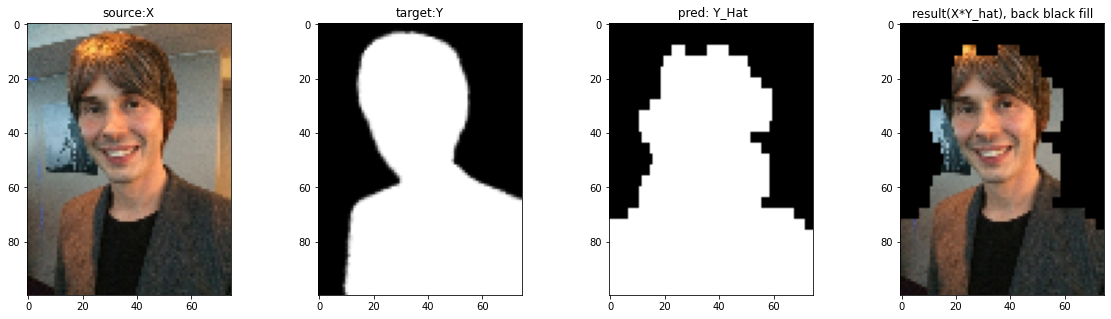

In [31]:
result = model.predict(test_images[:1])

plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(test_images[0])
plt.title('source:X')

plt.subplot(1, 4, 2)
plt.imshow(test_mattes[0], cmap='gray')
plt.title('target:Y')

plt.subplot(1, 4, 3)
plt.imshow(result[0], cmap='gray')
plt.title(' pred: Y_Hat')

plt.subplot(1, 4, 4)
plt.imshow(test_images[0] * result[0])
plt.title('result(X*Y_hat), back black fill')

In [32]:
result[0].min(), result[0].max()

(0.0, 1.0)

In [34]:
result[0][result[0] > 0.5] == 0

array([False, False, False, ..., False, False, False])

In [38]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def unet_like():
    inputs = Input((100, 75, 3))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D((2, 2))(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D((2, 2))(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, output_padding=(0, 1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, output_padding=(1, 0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, output_padding=(0, 1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, output_padding=(0, 1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c9)

    model = Model(inputs, outputs)
    
    return model

In [39]:
# unet_like() 모델을 할당 받고 서머리를 출력하는 코드를 작성하세요.
model_unet = unet_like()
model_unet.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100, 75, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 100, 75, 16)  448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 100, 75, 16)  64          conv2d_40[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 100, 75, 16)  0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

In [40]:
model_unet.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
hist = model_unet.fit(train_images,
                      train_mattes,
                      validation_data=(test_images, test_mattes_reshape),
                      epochs=5)

Epoch 1/5
54/54 [==============================] - 4s 49ms/step - loss: 0.1192 - accuracy: 0.7684 - val_loss: 0.2231 - val_accuracy: 0.6671
Epoch 2/5
54/54 [==============================] - 2s 44ms/step - loss: 0.0582 - accuracy: 0.8569 - val_loss: 0.3824 - val_accuracy: 0.4750
Epoch 3/5
54/54 [==============================] - 2s 43ms/step - loss: 0.0461 - accuracy: 0.8689 - val_loss: 0.1885 - val_accuracy: 0.6801
Epoch 4/5
54/54 [==============================] - 2s 42ms/step - loss: 0.0376 - accuracy: 0.8771 - val_loss: 0.1288 - val_accuracy: 0.7575
Epoch 5/5
54/54 [==============================] - 2s 42ms/step - loss: 0.0337 - accuracy: 0.8804 - val_loss: 0.1114 - val_accuracy: 0.7876


Text(0.5, 1.0, 'result(X*Y_hat), back black fill')

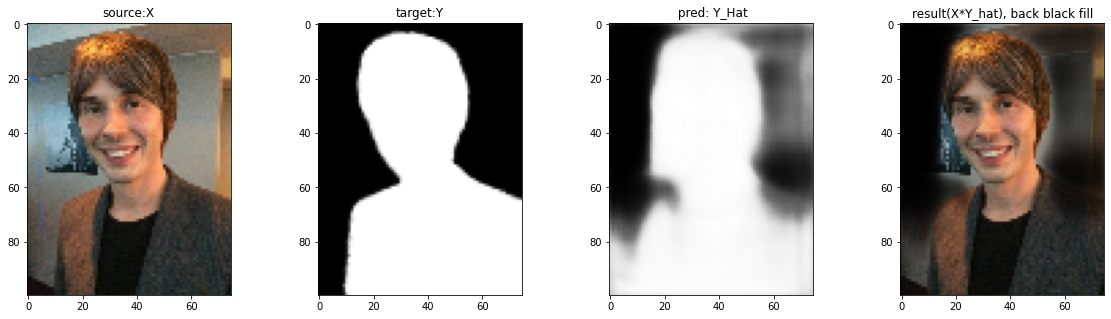

In [42]:
result = model_unet.predict(test_images[:1])

plt.figure(figsize=(20, 5))
gb k
plt.subplot(1, 4, 1)
plt.imshow(test_images[0])
plt.title('source:X')

plt.subplot(1, 4, 2)
plt.imshow(test_mattes[0], cmap='gray')
plt.title('target:Y')

plt.subplot(1, 4, 3)
plt.imshow(result[0], cmap='gray')
plt.title(' pred: Y_Hat')

plt.subplot(1, 4, 4)
plt.imshow(test_images[0] * result[0])
plt.title('result(X*Y_hat), back black fill')